In [13]:
# Imports and data loading
import pandas as pd
from pathlib import Path
from textblob import TextBlob
import numpy as np

DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

# Load news data
news_path = DATA_DIR / 'raw_analyst_ratings.csv'
df_news = pd.read_csv(news_path)
df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce')
df_news['date_day'] = df_news['date'].dt.date
df_news['headline'] = df_news['headline'].astype(str)

# Load stock data (example: AMZN)
stock = 'GOOG'
stock_path = PROCESSED_DIR / f'{stock}_processed.csv'
df_stock = pd.read_csv(stock_path, parse_dates=['Date'])
df_stock['date_day'] = df_stock['Date'].dt.date

In [14]:
# Sentiment analysis on headlines
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_news['sentiment'] = df_news['headline'].apply(get_sentiment)

# Aggregate daily sentiment per stock
daily_sentiment = df_news[df_news['stock'] == stock].groupby('date_day').agg(
    avg_sentiment=('sentiment', 'mean'),
    count=('sentiment', 'count')
).reset_index()

In [11]:
# Calculate daily returns for the stock
df_stock['return'] = df_stock['Close'].pct_change()

# Merge sentiment and returns by date
merged = pd.merge(df_stock, daily_sentiment, how='left', on='date_day')
merged['avg_sentiment'] = merged['avg_sentiment'].fillna(0)

# Calculate Pearson correlation
corr = merged[['avg_sentiment', 'return']].corr().iloc[0,1]
print(f'Pearson correlation between daily sentiment and returns for {stock}: {corr:.3f}')

Pearson correlation between daily sentiment and returns for AAPL: 0.032


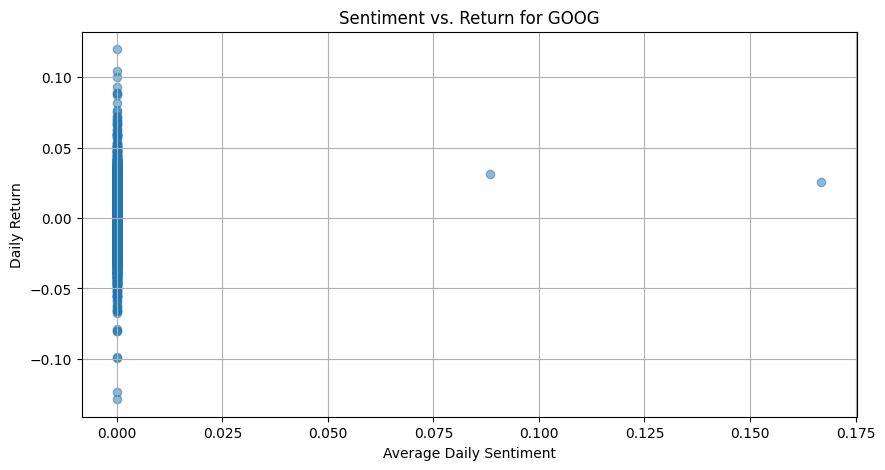

In [15]:
# Visualize sentiment vs. returns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(merged['avg_sentiment'], merged['return'], alpha=0.5)
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return')
plt.title(f'Sentiment vs. Return for {stock}')
plt.grid(True)
plt.show()

In [ ]:
# sentiment correlation analysis
from src.data_loader import DataLoader
from src.sentiment_analyzer import SentimentAnalyzer
from src.correlation_analyzer import CorrelationAnalyzer
import matplotlib.pyplot as plt
tickers = ['AMZN', 'GOOG', 'NVDA', 'MSFT']
results = {}
dl = DataLoader()
df_news = dl.load_news()
sa = SentimentAnalyzer()
df_news = sa.add_sentiment(df_news)
for ticker in tickers:
    df_stock = dl.load_stock(ticker)
    ca = CorrelationAnalyzer(ticker)
    daily_sentiment = ca.aggregate_daily_sentiment(df_news)
    merged, corr = ca.merge_and_correlate(df_stock, daily_sentiment)
    results[ticker] = {'corr': corr, 'merged': merged}
    print(f'{ticker}: Pearson correlation between daily sentiment and returns: {corr:.3f}')
    plt.figure(figsize=(8,4))
    plt.scatter(merged['avg_sentiment'], merged['return'], alpha=0.5)
    plt.xlabel('Average Daily Sentiment')
    plt.ylabel('Daily Return')
    plt.title(f'Sentiment vs. Return for {ticker}')
    plt.grid(True)
    plt.show()